<a href="https://colab.research.google.com/github/utkuyucel/Turkish-swearing-words-detection/blob/main/Discord_DD_ML_Based_Bot_04_05_22_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn import tree

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
def change(text):
  if text == "Negatif":
    return 1
  
  else:
    return 0

# df2["cyberbullying"] = df2["cyberbullying"].apply(change)

# df2.head()

# df2.to_csv("veri.csv")

In [61]:
df = pd.read_csv("son.csv", usecols = ["message", "cyberbullying"])
df2 = pd.read_csv("bully.csv", usecols = ["message", "cyberbullying"])
# df = pd.concat([df, df2, df3])
df = pd.concat([df, df2])
df.head()

,message,cyberbullying
0,rabbim kalan ömrünü geçen ömründen hayırlı eyl...,0
1,bir ateist olarak bu resmi gördükçe gözyaşları...,0
2,oo süpersin azıcık bize de bulaşsa,0
3,bende biliyorum benden bı bok olmicak,1
4,nerdesin len tirrek,1


In [62]:
# df = pd.concat([df, df2])
# df.head()
# df.to_csv("all_data.csv")

0    9111
1    8010
Name: cyberbullying, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


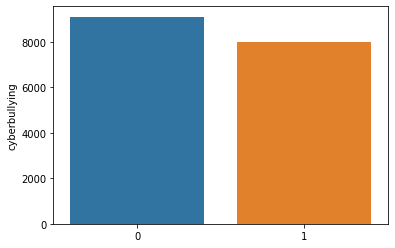

In [63]:
x = df["cyberbullying"].value_counts()
print(x)

sns.barplot(x.index, x)

In [64]:
df.isna().sum()

df = df.dropna(axis = 0)
df.isnull().sum()

message          0
cyberbullying    0
dtype: int64

In [65]:
# Word count

df["word_count"] = df["message"].apply(lambda x: len(str(x).split()))
print(df[df["cyberbullying"] == 1]["word_count"].mean())
print(df[df["cyberbullying"] == 0]["word_count"].mean())

9.497752808988764
10.245471511691733


In [66]:
#2. CHARACTER-COUNT
df['char_count'] = df['message'].apply(lambda x: len(str(x)))
print(df[df['cyberbullying']==1]['char_count'].mean()) #bullying tweets
print(df[df['cyberbullying']==0]['char_count'].mean()) #Non-bullying tweets

65.5139825218477
74.83532769788121


In [67]:
#3. UNIQUE WORD-COUNT
df['unique_word_count'] = df['message'].apply(lambda x: len(set(str(x).split())))
print(df[df['cyberbullying']==1]['unique_word_count'].mean()) #bullying tweets
print(df[df['cyberbullying']==0]['unique_word_count'].mean()) #Non-bullying tweets

9.216978776529338
9.915029092106707


In [68]:
import re
import string
#Text preprocessing

#1. Common text preprocessing
text = "   Selamlar bu bir deneme mesajıdır ama ne olacak bakalım acaba göreeceğiz: <br>, ?, :, ''  lol     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

selamlar bu bir deneme mesajıdır ama ne olacak bakalım acaba göreeceğiz lol


In [69]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
nltk.download('stopwords')
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('turkish')]
    return ' '.join(a)

text=stopword(text)
print(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
selamlar bir deneme mesajıdır olacak bakalım göreeceğiz lol


In [70]:
df['clean_text_tok']=[nltk.word_tokenize(i) for i in df['message']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [71]:
def clean_last(text): # listeden dışarıya çıkarttık. ## öbce boşuğu açıyoruz sonra dolduruyoruz..
  return " ".join(text)


def clean_eval(text): # listeden dışarıya çıkarttık. ## öbce boşuğu açıyoruz sonra dolduruyoruz..
  return "".join(text)
# df = df.drop(columns = ["word_count", "char_count", "unique_word_count"])



df["clean_text"] = df["clean_text_tok"].apply(clean_last)
df = df.drop(columns = ["clean_text_tok"])

df.head()

,message,cyberbullying,word_count,char_count,unique_word_count,clean_text
0,rabbim kalan ömrünü geçen ömründen hayırlı eyl...,0,7,50,7,rabbim kalan ömrünü geçen ömründen hayırlı eyl...
1,bir ateist olarak bu resmi gördükçe gözyaşları...,0,9,64,9,bir ateist olarak bu resmi gördükçe gözyaşları...
2,oo süpersin azıcık bize de bulaşsa,0,6,34,6,oo süpersin azıcık bize de bulaşsa
3,bende biliyorum benden bı bok olmicak,1,6,37,6,bende biliyorum benden bı bok olmicak
4,nerdesin len tirrek,1,3,19,3,nerdesin len tirrek


In [72]:
X_train, X_val, y_train, y_val = train_test_split(df["clean_text"],
                                                  df["cyberbullying"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

In [73]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) 

In [74]:
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# nb_tfidf = MultinomialNB()
nb_tfidf = tree.DecisionTreeClassifier()
# nb_tfidf = KNeighborsClassifier(n_neighbors=3)
# nb_tfidf = RandomForestClassifier(n_estimators = 100)

nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 
print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1814
           1       0.88      0.92      0.90      1610

    accuracy                           0.90      3424
   macro avg       0.90      0.90      0.90      3424
weighted avg       0.90      0.90      0.90      3424

Confusion Matrix:
 [[1609  205]
 [ 128 1482]]
AUC: 0.9037434857937231


In [76]:
def eval(text):
  text = preprocess(text)
  text = stopword(text)
  text = clean_eval(text)

  X_vector = tfidf_vectorizer.transform([text])
  predict = nb_tfidf.predict(X_vector)
  prob = nb_tfidf.predict_proba(X_vector)[:,1][0]
  return predict[0], prob

In [77]:
text, prb = eval("Ananı sikerim senin orospunun evladı")
print(text, " ", prb)

1   1.0


In [78]:
text, prb = eval("Selamlar, nasılsınız?")
print(text, prb)

0 0.0


In [79]:
text, prb = eval("Sa herkese")
print(text, prb)

0 0.0


In [80]:
text, prb = eval("Ben buradaki goygoy muhabbete neden katılmayıp gidip birşeyler anlatan yayınlara katılıyorum diye bir soru ile de karşılaştım")
print(text, prb)

0 0.0


In [81]:
text, prb = eval("Ben buradaki goygoy muhabbete neden katılmayıp gidip birşeyler anlatan yayınlara katılıyorum diy cibilliyetini sikeyim")
print(text, prb)

1 1.0


In [82]:
text, prb = eval("ananı sikeyim")
print(text, prb)

1 1.0
